In [79]:
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import numpy as np
import pandas as pd
import os
import math

%matplotlib inline

In [111]:
from trackml.dataset import load_event
hits_list = [load_event('data/train_100_events/event00000' + str(i))[0] for i in range (1000,1100)]
hits = pd.concat(hits_list, axis = 0)
cells_list = [load_event('data/train_100_events/event00000' + str(i))[1] for i in range (1000,1100)]
cells = pd.concat(cells_list, axis = 0)
particles_list = [load_event('data/train_100_events/event00000' + str(i))[2] for i in range (1000,1100)]
particles = pd.concat(particles_list, axis = 0)
truth_list = [load_event('data/train_100_events/event00000' + str(i))[3] for i in range (1000,1100)]
truth = pd.concat(truth_list, axis = 0)

In [112]:
def get_counts_of_id(id_val, df):
    return len(df[df.hit_id == id_val])

f = lambda x: get_counts_of_id(3, x)
sum(map(f, hits_list))

100

In [113]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [114]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [115]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [116]:
particles.size

9712314

(array([2.33126e+05, 5.10850e+04, 8.50300e+04, 8.16000e+04, 2.26186e+05,
        3.45775e+05, 5.08740e+04, 5.39800e+03, 6.50000e+01, 7.00000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

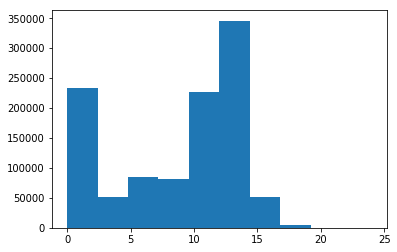

In [117]:
plt.hist(particles.nhits)

In [118]:
pos_part = particles[particles.q == 1]
neg_part = particles[particles.q == -1]

(array([1.45133e+05, 3.07830e+04, 3.35920e+04, 6.09430e+04, 1.11618e+05,
        1.41537e+05, 6.95210e+04, 3.09100e+03, 2.10000e+02, 1.30000e+01]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

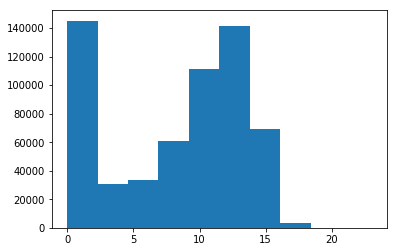

In [119]:
plt.hist(pos_part.nhits)

(array([8.79930e+04, 2.03020e+04, 3.41450e+04, 3.79500e+04, 1.14568e+05,
        1.63092e+05, 2.24990e+04, 2.13500e+03, 1.90000e+01, 2.00000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

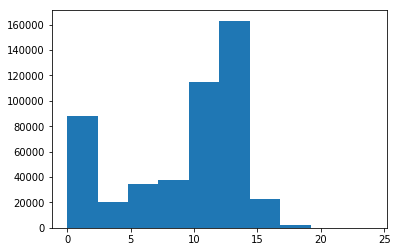

In [120]:
plt.hist(neg_part.nhits)

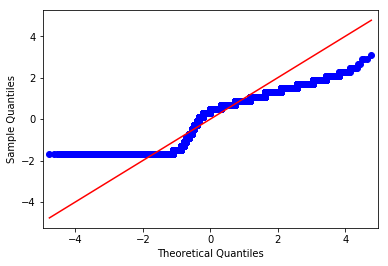

In [121]:
fig = qqplot(particles.nhits, fit = True, line='s')


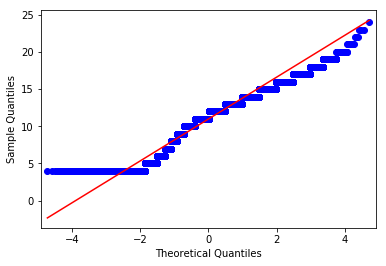

In [122]:
trunc_nhits = particles[particles.nhits >3].nhits
fig = qqplot(trunc_nhits, line='s')

### Analysis

Wtf is going with the LHS of the QQ plot?

(array([5.43260e+04, 5.71710e+04, 8.16000e+04, 2.26186e+05, 2.70160e+05,
        1.12117e+05, 1.86080e+04, 1.16200e+03, 6.50000e+01, 7.00000e+00]),
 array([ 4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.]),
 <a list of 10 Patch objects>)

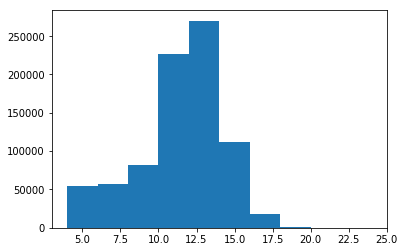

In [123]:
plt.hist(trunc_nhits)


# Adding Noise Because Discrete Data Looks Weird

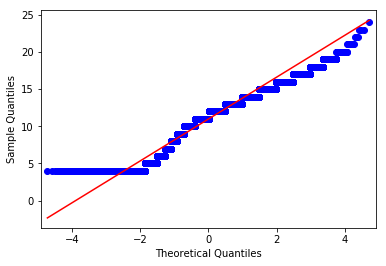

In [124]:
s = 0.0001
eps = np.random.normal(0,s, trunc_nhits.shape)
trunc_nhits_random = trunc_nhits + eps

fig = qqplot(trunc_nhits_random, line='s')

# Analysis

By adding noise, we see that normality is restored, so we can trust that QQ-plot is working

# Straight Shot Paths Through Analyzing Truth

# Is total hits in an event normally distributed?

(array([ 1.,  1.,  6., 18., 20., 14., 23., 14.,  1.,  2.]),
 array([ 77089. ,  83236.9,  89384.8,  95532.7, 101680.6, 107828.5,
        113976.4, 120124.3, 126272.2, 132420.1, 138568. ]),
 <a list of 10 Patch objects>)

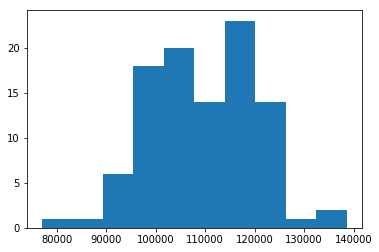

In [125]:
hits_per_event = [hits.shape[0] for hits in hits_list]
plt.hist(hits_per_event)

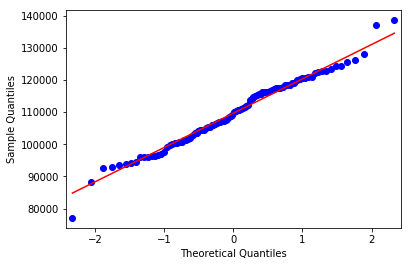

In [126]:
fig = qqplot(np.array(hits_per_event), line='s')

## Conclusion

The total number of hist per event is normally distributed.